## Setup

In [ ]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt

In [ ]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

## Quick look at the data

In [ ]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


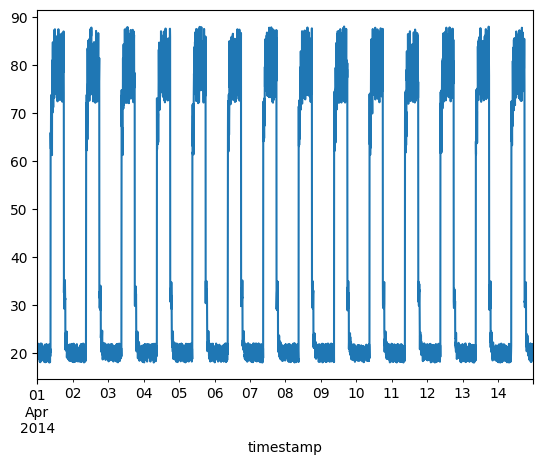

In [ ]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

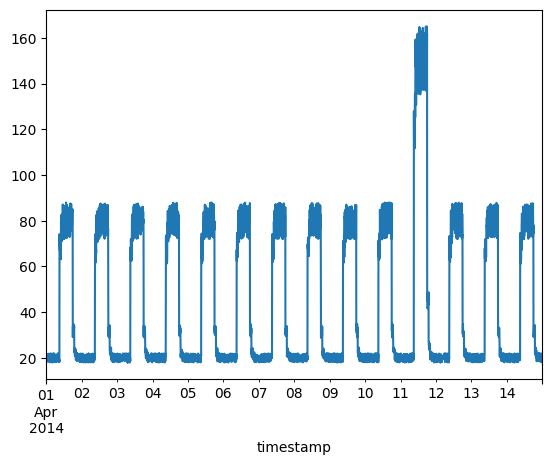

In [ ]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

## Prepare training data

Get data values from the training timeseries data file and normalize the
`value` data. We have a `value` for every 5 mins for 14 days.

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total

In [ ]:

# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [ ]:
TIME_STEPS = 288


# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


In [ ]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.LSTM(units=64, return_sequences=True),
        layers.Dropout(rate=0.2),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 288, 64)             │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 288, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 288, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 288, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 288, 64)             │          33,024 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,944 (324.00 KB)

 Trainable params: 82,944 (324.00 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

In [ ]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.8481 - val_loss: 0.4008
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.3408 - val_loss: 0.2159
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2071 - val_loss: 0.1784
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1633 - val_loss: 0.1268
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1240 - val_loss: 0.1115
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1095 - val_loss: 0.0984
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1016 - val_loss: 0.0969
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0963 - val_loss: 0.0886
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0884 - val_loss: 0.0827
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0828 - val_loss: 0.0782
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0788 - val_loss: 0.0742
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0

Let's plot training and validation loss to see how the training went.

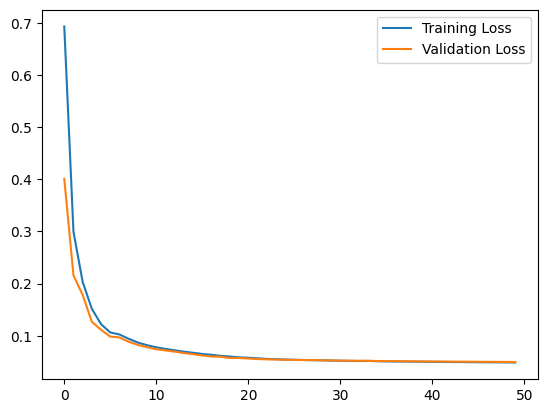

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


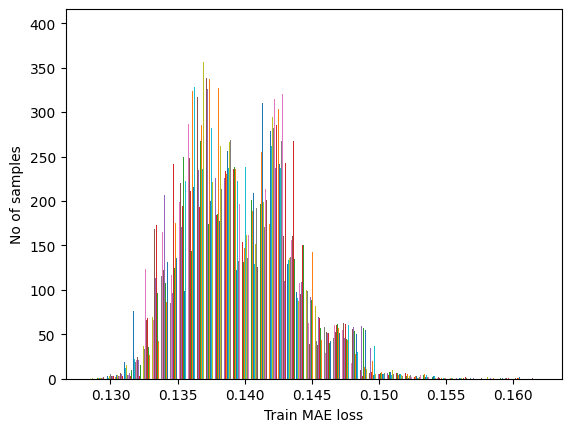

Reconstruction error threshold:  0.1620132714536805


In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

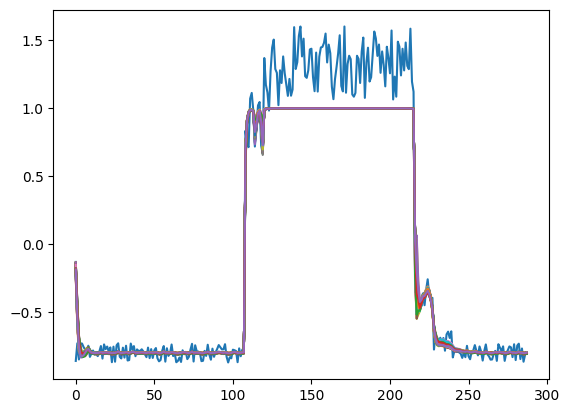

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

### Prepare test data

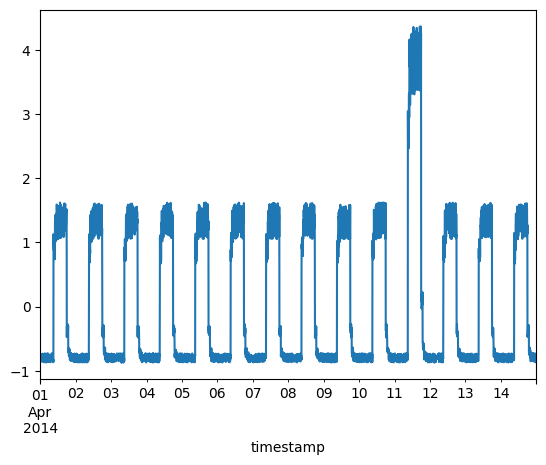

Test input shape:  (3745, 288, 1)
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


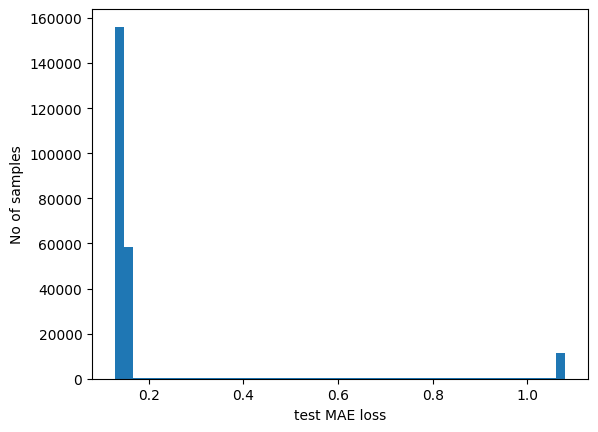

Number of anomaly samples:  25449
Indices of anomaly samples:  (array([ 50497,  50506,  50510, ..., 198140, 198141, 198142]),)


In [ ]:

df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
x_test

array([[[-0.80767185],
        [-0.78133079],
        [-0.80053474],
        ...,
        [-0.84984182],
        [-0.84637559],
        [-0.86378412]],

       [[-0.78133079],
        [-0.80053474],
        [-0.74609097],
        ...,
        [-0.84637559],
        [-0.86378412],
        [-0.74187577]],

       [[-0.80053474],
        [-0.74609097],
        [-0.792482  ],
        ...,
        [-0.86378412],
        [-0.74187577],
        [-0.79336052]],

       ...,

       [[-0.82278269],
        [-0.80756241],
        [-0.78271553],
        ...,
        [-0.86774221],
        [-0.76348065],
        [-0.7789844 ]],

       [[-0.80756241],
        [-0.78271553],
        [-0.86038742],
        ...,
        [-0.76348065],
        [-0.7789844 ],
        [-0.86134756]],

       [[-0.78271553],
        [-0.86038742],
        [-0.73531485],
        ...,
        [-0.7789844 ],
        [-0.86134756],
        [-0.73281036]]])

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [ ]:
anomalies

array([False, False, False, ..., False, False, False])

IndexError: index 0 is out of bounds for axis 0 with size 0

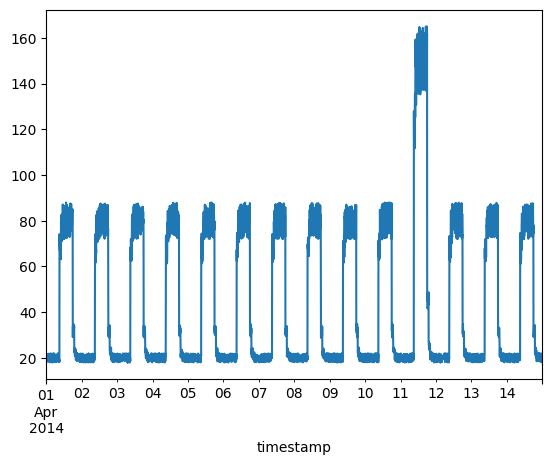

In [ ]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()